# Generative Adversarial Network
by Búgvi Benjamin Magnussen and Nikolaj Bläser

In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
# Swap this boolean to choose between convolutional networks and dense (maxout) networks
use_convolutions = True
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data preprocessing

In [3]:
mnist = tf.keras.datasets.mnist.load_data()
(X_train, y_train), (X_test, y_test) = mnist
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [4]:
def normalize(images):
  return (images - 127.5) / 127.5

In [5]:
X_train = normalize(X_train)
X_test = normalize(X_test)

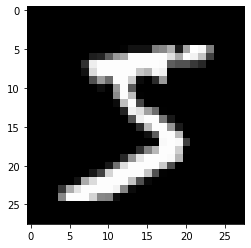

In [6]:
image = X_train[0]
plt.imshow(image, cmap='gray')

In [7]:
IMAGE_WIDTH = image.shape[0]
IMAGE_HEIGHT = image.shape[1]

In [8]:
BATCH_SIZE = 256
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(len(X_train)).batch(BATCH_SIZE)

# Activation Functions

In [ ]:
# The code is from tensorflow.contrib.layers.maxout
def maxout(inputs, num_units, axis=-1):
  '''
  inputs: Tensor input
  num_units: The num of unit keeped after amxout
  axis: The dimension max op performed
  scope: Optional scope for variable_scope
     Note: This is a slightly modified version. Replaced some unused API functions
  '''
  shape = inputs.get_shape().as_list()
  num_channels = shape[axis]
  if num_channels % num_units:
    raise ValueError('number of features({}) is not '
                      'a multiple of num_units({})'.format(
                          num_channels, num_units))
  shape[axis] = -1
  shape += [num_channels // num_units]

  # Dealing with batches with arbitrary sizes
  for i in range(len(shape)): # This is used to handle the case where None is included in the shape
    if shape[i] is None:
      shape[i] = tf.shape(inputs)[i]
  outputs = tf.reduce_max( tf.reshape(inputs, shape), -1)
  return outputs

# Layer Functions

In [ ]:

def denseRelu(inputs, weights, bias):
  return tf.nn.relu(tf.nn.bias_add(tf.matmul(inputs, weights), bias))

def denseLeakyRelu(inputs, weights, bias):
  return tf.nn.leaky_relu(tf.nn.bias_add(tf.matmul(inputs, weights), bias))

def denseTanh(inputs, weights, bias):
  return tf.nn.tanh(tf.nn.bias_add(tf.matmul(inputs, weights), bias))

def denseSigmoid(inputs, weights, bias):
  return tf.nn.sigmoid(tf.nn.bias_add(tf.matmul(inputs, weights), bias))


def denseMaxout(inputs, weights, bias, num_of_units=2, dropout_rate=0.5):
  z = tf.nn.bias_add(tf.matmul(inputs, weights), bias)
  z_dropout = tf.nn.dropout(z, rate=dropout_rate)
  return maxout(z_dropout, num_of_units)

def conv2dLeakyRelu(inputs, filters, channels, width, height, stride_size, dropout_rate=0.3):
  inputs = tf.reshape(inputs, [-1, width, height, channels])
  z = tf.nn.leaky_relu(tf.nn.conv2d(inputs, filters, [stride_size, stride_size], padding='SAME'))
  out = tf.nn.dropout(z, rate=dropout_rate)
  return out

def conv2d_transpose(inputs, filters, channels, width, height, output_shape, stride_size):
  inputs = tf.reshape(inputs, [-1, width, height, channels])
  out = tf.nn.conv2d_transpose(inputs, filters, output_shape=output_shape, strides=[1, stride_size, stride_size, 1]) #padding is same
  return out


# Parameter Initialization

In [ ]:
initializer = tf.initializers.glorot_normal()
bias_initializer = tf.initializers.zeros()

def get_biases(n_units, name):
  return tf.Variable(bias_initializer(n_units, dtype=tf.float32), name = name, trainable = True, dtype=tf.float32)

def get_weights(shape, name):
  return tf.Variable(initializer(shape, dtype=tf.float32), name = name, trainable = True, dtype=tf.float32)

def get_filters(shape, name):
  return tf.Variable(initializer(shape, dtype=tf.float32), name = name, trainable = True, dtype=tf.float32)   

# Discriminator - Maxout Network

In [ ]:
if (not use_convolutions):
  discriminator_biases = [
    get_biases(1024, 'bias0'),
    get_biases(512, 'bias1'),
    get_biases(1, 'bias2')
  ]

  discriminator_weights = [
    get_weights([image.shape[0] * image.shape[1], 1024], 'weights0'),
    get_weights([256, 512], 'weights1'),
    get_weights([256, 1], 'weights2'),
  ]

  discriminator_parameters = discriminator_weights + discriminator_biases

In [ ]:
if(not use_convolutions):
  dropout_rate = 0.5

  @tf.function
  def discriminator(x):
    x = tf.cast(x, dtype=tf.float32)
    x = tf.reshape(x, shape=[x.shape[0], x.shape[1] * x.shape[2]])
    d1 = denseMaxout(x, discriminator_weights[0], discriminator_biases[0], num_of_units=256, dropout_rate=dropout_rate)
    d2 = denseMaxout(d1, discriminator_weights[1], discriminator_biases[1], num_of_units=256, dropout_rate=dropout_rate)
    return denseSigmoid(d2, discriminator_weights[2], discriminator_biases[2])

# Generator - Dense Network

In [ ]:
if(not use_convolutions):
  generator_biases = [
    get_biases(256, 'bias0'),
    get_biases(512, 'bias1'),
    get_biases(1024, 'bias2'),
    get_biases(image.shape[0] * image.shape[1], 'bias3')
  ]

  generator_weights = [
    get_weights([100, 256], 'weights0'),
    get_weights([256, 512], 'weights1'),
    get_weights([512, 1024], 'weights2'),
    get_weights([1024, image.shape[0] * image.shape[1]], 'weights3')
  ]

  generator_parameters = generator_weights + generator_biases

In [ ]:
if(not use_convolutions):
  @tf.function
  def generator(x):
    x = tf.cast(x, dtype=tf.float32)
    d1 = denseLeakyRelu(x, generator_weights[0], generator_biases[0])
    d2 = denseLeakyRelu(d1, generator_weights[1], generator_biases[1])
    d3 = denseLeakyRelu(d2, generator_weights[2], generator_biases[2])
    output = denseTanh(d3, generator_weights[3], generator_biases[3])
    return tf.reshape(output, [x.shape[0], IMAGE_WIDTH, IMAGE_HEIGHT])

# Discriminator - Convolutional Network

In [ ]:
if(use_convolutions):
  discriminator_biases = [

  ]

  discriminator_weights = [
    get_filters([5, 5, 1, 64], 'filters1'),
    get_filters([5, 5, 64, 128], 'filters2'),
    get_weights([7*7*128, 1], 'weights0') 
  ]

  discriminator_parameters = discriminator_weights + discriminator_biases

In [ ]:
if(use_convolutions):
  dropout_rate = 0.3

  @tf.function
  def discriminator(x):
    batchsize = x.shape[0]
    x = tf.cast(x, dtype=tf.float32)
    d1 = conv2dLeakyRelu(x, discriminator_weights[0], channels=1, width=28, height=28, stride_size=2, dropout_rate=dropout_rate)
    d2 = conv2dLeakyRelu(d1, discriminator_weights[1], channels=64, width=14, height=14, stride_size=2, dropout_rate=dropout_rate)
    d2 = tf.reshape(d2, [batchsize, -1])
    return tf.nn.sigmoid(tf.matmul(d2, discriminator_weights[2]))

# Generator - Convolutional Network

In [ ]:
if(use_convolutions):
  generator_biases = [
  ]

  generator_weights = [
    get_weights([100, 7*7*256], 'weights0'),
    get_filters([5, 5, 128, 256], 'filters1'),      
    get_filters([5, 5, 64, 128], 'filters0'),
    get_filters([5, 5, 1, 64], 'filters1')   
  ]

  generator_parameters = generator_weights + generator_biases

In [ ]:
if(use_convolutions):
  @tf.function
  def generator(x):
    x = tf.cast(x, dtype=tf.float32)
    d1 = tf.nn.leaky_relu(tf.matmul(x, generator_weights[0]))
    d2 = tf.nn.leaky_relu(conv2d_transpose(inputs=d1, filters=generator_weights[1], channels=256, width=7, height=7, output_shape=(d1.shape[0], 7, 7, 128), stride_size=1))
    d3 = tf.nn.leaky_relu(conv2d_transpose(inputs=d2, filters=generator_weights[2], channels=128, width=7, height=7, output_shape=(d2.shape[0], 14, 14, 64), stride_size=2))
    output = tf.nn.tanh(conv2d_transpose(inputs=d3, filters=generator_weights[3], channels=64, width=14, height=14, output_shape=(d3.shape[0], 28, 28, 1), stride_size=2))
    return tf.reshape(output, [x.shape[0], IMAGE_WIDTH, IMAGE_HEIGHT])



# Generated Image Plotting

In [ ]:
def generate_image(input):
  gen_img = generator(input)
  f, ax = plt.subplots(1,4, figsize=(12, 48))
  ax[0].imshow((gen_img[0]) , cmap='gray')
  ax[1].imshow((gen_img[1]) , cmap='gray')
  ax[2].imshow((gen_img[2]) , cmap='gray')
  ax[3].imshow((gen_img[3]) , cmap='gray')
  plt.pause(0.05)

# Loss Functions

In [ ]:
def discriminator_loss(real_output, fake_output):
    assert len(real_output) == len(fake_output)
    return tf.math.reduce_mean(tf.math.reduce_sum(tf.math.log(real_output) + tf.math.log(1 - fake_output)))

In [ ]:
def generator_loss(fake_output):
    return tf.math.reduce_mean(tf.math.reduce_sum(tf.math.log(1 - fake_output)))


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(4e-5, beta_1=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(-1e-4, beta_1=0.9) # negative because we want to maximise


# Inception Score

In [ ]:
# Source: https://machinelearningmastery.com/how-to-implement-the-inception-score-from-scratch-for-evaluating-generated-images/
# calculate the inception score for p(y|x)
def calculate_inception_score(p_yx, eps=1E-16):
  # calculate p(y)
  p_y = np.expand_dims(p_yx.mean(axis=0), 0)
  # kl divergence for each image
  kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))
  # sum over classes
  sum_kl_d = kl_d.sum(axis=1)
  # average over images
  avg_kl_d = np.mean(sum_kl_d)
  # undo the logs
  is_score = np.exp(avg_kl_d)
  return is_score

# Loading pretrained classifier weight

In [ ]:
np_weights = np.load('./Classifier_params/weights.npy', allow_pickle=True)
np_biases = np.load('./classifier_params/biases.npy', allow_pickle=True)
classifier_weights = [tf.Variable(w, trainable = True, dtype=tf.float64) for w in np_weights]
classifier_biases = [tf.Variable(w, trainable = True, dtype=tf.float64) for w in np_biases]

# Classifier

In [ ]:
dropout_rate = 0.5

@tf.function
def classifier(x):
  x = tf.cast(x, dtype=tf.float64)
  x = tf.reshape(x, shape=[x.shape[0], x.shape[1] * x.shape[2]])
  d1 = denseMaxout(x, classifier_weights[0], classifier_biases[0], num_of_units=240, dropout_rate=dropout_rate)
  d2 = denseMaxout(d1, classifier_weights[1], classifier_biases[1], num_of_units=240, dropout_rate=dropout_rate)
  return tf.nn.softmax(tf.nn.bias_add(tf.matmul(d2, classifier_weights[2]), classifier_biases[2]))

# Inception Plot

In [ ]:
def generate_inception_plot(epochs, input):
  plt.plot(epochs, input)
  plt.xlabel('Epochs')
  plt.ylabel('Inception Score')
  plt.pause(0.05)

# Hyperparameters

In [ ]:
EPOCHS = 500
K = 1

# Training

In [ ]:
def train_step(real_images, index):
  generated_images = generator(tf.random.normal(shape = [len(real_images), 100]))
  with tf.GradientTape() as disc_tape:
    real_output = discriminator(real_images)
    fake_output = discriminator(generated_images)
    
    disc_loss = discriminator_loss(real_output, fake_output)
  
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_parameters)
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_parameters))

  if (index % K == 0):
    with tf.GradientTape() as gen_tape:
      generated_images = generator(tf.random.normal(shape = [BATCH_SIZE, 100]))
      fake_output = discriminator(generated_images)
      gen_loss = generator_loss(fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator_parameters)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_parameters))

In [ ]:
from IPython.display import clear_output
test_input = tf.random.normal([4, 100], seed=12345)
# used for inception score
inception_validation_input = tf.random.normal([10000, 100])
inception_scores = [0] * EPOCHS
epochs = list(range(0, EPOCHS))

for e in range(EPOCHS):
  clear_output(wait=True)
  print("Epochs: " + str(e+1) + "\\" + str(EPOCHS))
  generate_image(test_input)
  inception_scores[e] = calculate_inception_score(classifier(generator(inception_validation_input)).numpy())
  generate_inception_plot(epochs, inception_scores)
  plt.clf()
  for index, real_images in enumerate(X_train):
    train_step(real_images, index)


# Inception Test

In [ ]:
generated_classified_images = classifier(generator(tf.random.normal([10000, 100])))
print(calculate_inception_score(generated_classified_images.numpy()))